In [1]:
%matplotlib inline
# Handle table-like data and matrices
import numpy as np
import pandas as pd
import re

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LassoLarsCV,Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier, RandomForestRegressor

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

# Visualisation
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
sns.set(style="ticks")

C:\Users\kefor\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Summary
--------------
Burlington is a small city located on the shores of Lake Champlain in Vermont.  About an hour south of the canadian border it has some of the quantness and weirdness of Vermont and the real estate market has been booming for a long time.  The website for getting the data set: https://data.burlingtonvt.gov/City-Hall/City-of-Burlington-Property-Details/k7ck-hpwh

Null Hypothesis
-----
There is a point where the return for the investment increases given a set of variables where the return on the investment reaches a threashold of ideal purchase.  We will use machine learning to predict the best properties and attributes to look for a return on investment.

The Data
----------------
First pull in th CSV with all the housing data and display the initial information. Some will be more useful than other
to determine what is the most return for the value and here are some values that could be dropped.  There are also a bunch of values that I will drop.  Since my focus is on housing rather than public or manufacturing spaces I have to trim it.

In [2]:
train_df = pd.read_csv('~/Desktop/PythonLearning/City_of_Burlington_Property_Details.csv')
print(train_df.head())

   AccountNumber       ParcelID     SpanNumber StreetNumber AlternateNumber  \
0           7502  049-3-187-000  114-035-17502          227             NaN   
1          10680  043-3-085-001  114-035-20680           53             NaN   
2           9512  057-1-013-000  114-035-19512           47             NaN   
3           7960  050-2-019-001  114-035-17960          258             NaN   
4           9255  056-3-017-000  114-035-19255           47             NaN   

         StreetName Unit            CuO1LastName CuO1FirstName CuO2LastName  \
0        COLLEGE ST  NaN                CITY DPW           NaN          NaN   
1           WARD ST  NaN                 EMERSON     DEBORAH A      EMERSON   
2          SEARS LN  NaN      CITY OF BURLINGTON           NaN          NaN   
3  SOUTH WILLARD ST  NaN  CHAMPLAIN COLLEGE INC.           NaN          NaN   
4        CENTRAL AV  NaN                  BRANDT       RICHARD          NaN   

           ...          LegalReference GrantorLast

In [3]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10832 entries, 0 to 10831
Data columns (total 38 columns):
AccountNumber            10832 non-null int64
ParcelID                 10832 non-null object
SpanNumber               10832 non-null object
StreetNumber             10827 non-null object
AlternateNumber          1074 non-null object
StreetName               10832 non-null object
Unit                     2076 non-null object
CuO1LastName             10831 non-null object
CuO1FirstName            8519 non-null object
CuO2LastName             5633 non-null object
CuO2FirstName            5107 non-null object
CuO3LastName             572 non-null object
CuO3FirstName            461 non-null object
LandUse                  10832 non-null object
CurrentAcres             10832 non-null float64
TotalGrossArea           10832 non-null int64
FinishedArea             10832 non-null float64
CurrentValue             10832 non-null float64
CurrentLandValue         10832 non-null int64
Current

Residential Housing
------
First step it to reduce the data set to just residential housing only by taking only rows with the correct value under LandUse.  

Single Family
Residential Condo
Two Family
Three Family
Five Family Plus
Four Family 
Commercial Condo
Seasonal home 
Commercial Land


Correlation
---------
The simpliest way to get a feeling for the usefulness of the values from the start is a quick heatmap.  My primary interest is correlation to SalePrice and CurrentValue.  Interestingly, Depreciation seems to have little correlation with anything else, something that surprises me. When we get done this should have a lot more features and be much more useful.

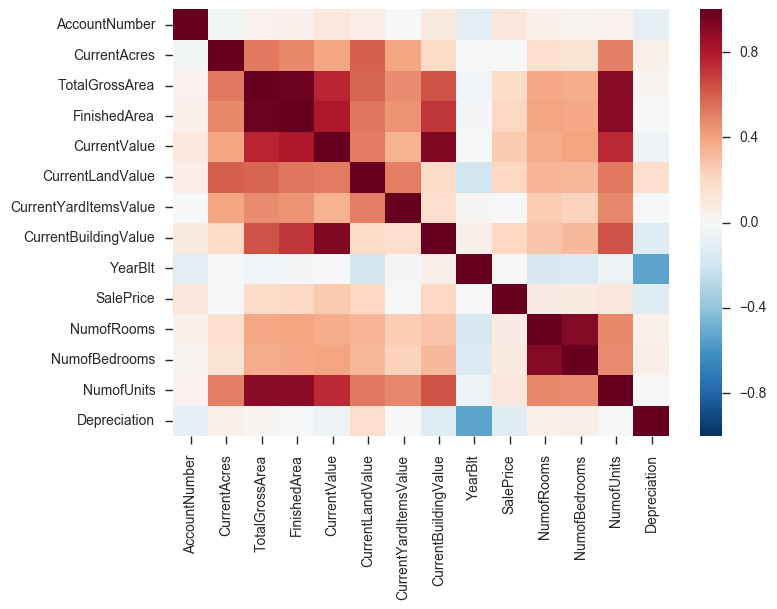

In [5]:
corr = train_df.corr()
sns.heatmap(corr)
plt.show()

In [6]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9440 entries, 1 to 10831
Data columns (total 38 columns):
AccountNumber            9440 non-null int64
ParcelID                 9440 non-null object
SpanNumber               9440 non-null object
StreetNumber             9440 non-null object
AlternateNumber          831 non-null object
StreetName               9440 non-null object
Unit                     2059 non-null object
CuO1LastName             9439 non-null object
CuO1FirstName            8072 non-null object
CuO2LastName             5205 non-null object
CuO2FirstName            4914 non-null object
CuO3LastName             521 non-null object
CuO3FirstName            437 non-null object
LandUse                  9440 non-null object
CurrentAcres             9440 non-null float64
TotalGrossArea           9440 non-null int64
FinishedArea             9440 non-null float64
CurrentValue             9440 non-null float64
CurrentLandValue         9440 non-null int64
CurrentYardItemsValue

Triming
----------
In order to save time later on, I am going to trim some data off the set, specifically first name, street nnumber, account number and parcel ID.  These should be unique to each record or in the case of the first name, just not useful.

In [7]:
# Delete all the columns that are not relevant 
del train_df['StreetNumber']
del train_df['AccountNumber']
del train_df['ParcelID']
del train_df['AlternateNumber']
del train_df['Unit']
del train_df['CuO1FirstName']
del train_df['CuO2LastName']
del train_df['CuO2FirstName']
del train_df['CuO3LastName']
del train_df['CuO3FirstName']
del train_df['GrantorLastName']

Find and fill missing values

In [8]:
train_df.isnull().sum()

SpanNumber                  0
StreetName                  0
CuO1LastName                1
LandUse                     0
CurrentAcres                0
TotalGrossArea              0
FinishedArea                0
CurrentValue                0
CurrentLandValue            0
CurrentYardItemsValue       0
CurrentBuildingValue        0
BuildingType                1
HeatFuel                   53
HeatType                   17
Grade                       1
YearBlt                     0
SaleDate                 5066
SalePrice                   0
LegalReference              0
NumofRooms                  0
NumofBedrooms               0
Baths                       0
NumofUnits                  0
ZoningCode                 22
Foundation                 38
Depreciation                0
PropertyCenterPoint       134
dtype: int64

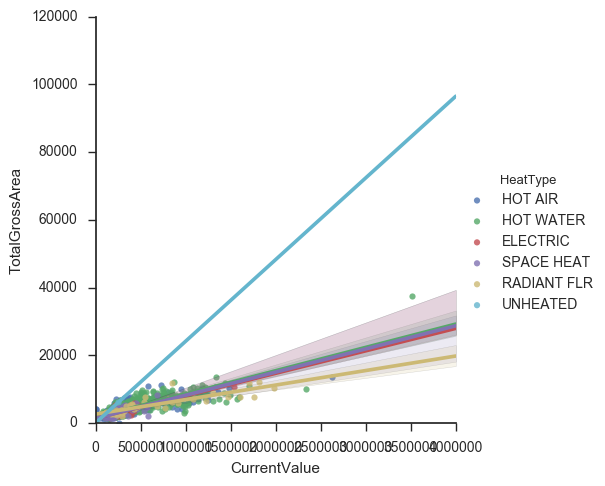

In [30]:
# plot distribution of family size

singledf = train_df.loc[(train_df["LandUse"] == "1 Family")]
g = sns.lmplot(x="CurrentValue", y="TotalGrossArea", hue="HeatType", data=singledf, x_jitter=.3, sharey=False)
g.set(ylim=(0, None), xlim=(0, None))

Building Type
------
Building Types are widespread and only partially useful. In order to make it a more useful feature, some engineering is needed to bring it into more useful form.

In [11]:
#print(train_df['BuildingType'].value_counts())

#train_df.loc[train_df["BuildingType"] == "TOWNHS END", BuildingType"] = 'Townhouse'            
#train_df.loc[train_df["BuildingType"] == "NONE", "BuildingType"] = "UNIQUE"

Heat Fuel
--------
Here are a couple of data cleansing steps to remove outliers for a better machine learning model.  

In [12]:
print(train_df['HeatFuel'].value_counts())

# reassign uncommon values
train_df.loc[train_df["HeatFuel"] == "NONE", "HeatFuel"] = "UNIQUE"
train_df.loc[train_df["HeatFuel"] == "WOOD", "HeatFuel"] = "UNIQUE"
train_df.loc[train_df["HeatFuel"] == "WOOD COMBO", "HeatFuel"] = "UNIQUE"
train_df.loc[train_df["HeatFuel"] == "PROPANE", "HeatFuel"] = "UNIQUE"

# Fill missing values with Gas
train_df["HeatFuel"] = train_df["HeatFuel"].fillna("GAS")

print(train_df['HeatFuel'].value_counts())

GAS           8119
OIL            986
ELECTRIC       271
PROPANE          9
WOOD COMBO       1
WOOD             1
Name: HeatFuel, dtype: int64
GAS         8172
OIL          986
ELECTRIC     271
UNIQUE        11
Name: HeatFuel, dtype: int64


In [13]:
# train_df[["LandUse", "CurrentValue"]].groupby(['LandUse'], as_index=False).mean()


In [10]:
# Fill missing values with Gas
train_df["CuO1LastName"] = train_df["CuO1LastName"].fillna("None")
train_df["BuildingType"] = train_df["BuildingType"].fillna("GAS")
train_df["Grade"] = train_df["Grade"].fillna("GOOD")
train_df["YearBlt"].fillna(train_df["YearBlt"].median(), inplace=True)

# train_df.median()['YearBlt']

train_df.isnull().sum()

SpanNumber                  0
StreetName                  0
CuO1LastName                0
LandUse                     0
CurrentAcres                0
TotalGrossArea              0
FinishedArea                0
CurrentValue                0
CurrentLandValue            0
CurrentYardItemsValue       0
CurrentBuildingValue        0
BuildingType                0
HeatFuel                   53
HeatType                   17
Grade                       0
YearBlt                     0
SaleDate                 5066
SalePrice                   0
LegalReference              0
NumofRooms                  0
NumofBedrooms               0
Baths                       0
NumofUnits                  0
ZoningCode                 22
Foundation                 38
Depreciation                0
PropertyCenterPoint       134
dtype: int64

Heat Type
----------
There are several loose ends for the Heat Types.  Here we get a view of some stragglers and correct or modify values to reduce the variables.

In [14]:
print(train_df['HeatType'].value_counts())

# reassign uncommon values
train_df.loc[train_df["HeatType"] == "TYPICAL", "HeatType"] = "HOT WATER"
train_df.loc[train_df["HeatType"] == "Hot Water", "HeatType"] = "HOT WATER"
train_df.loc[train_df["HeatType"] == "H WATER/RADI", "HeatType"] = "HOT WATER"
train_df.loc[train_df["HeatType"] == "STEAM", "HeatType"] = "HOT WATER"
train_df.loc[train_df["HeatType"] == "HEAT PUMP", "HeatType"] = "HOT WATER"
train_df.loc[train_df["HeatType"] == "HVAC", "HeatType"] = "HOT AIR"

# Fill missing 52 values with Hot Water
train_df["HeatType"] = train_df["HeatType"].fillna("HOT WATER")

print(train_df['HeatType'].value_counts())

HOT WATER       4208
HOT AIR         3828
SPACE HEAT       729
ELECTRIC         288
STEAM            161
HEAT PUMP         62
RADIANT FLR       55
H WATER/RADI      49
HVAC              41
UNHEATED           1
TYPICAL            1
Name: HeatType, dtype: int64
HOT WATER      4498
HOT AIR        3869
SPACE HEAT      729
ELECTRIC        288
RADIANT FLR      55
UNHEATED          1
Name: HeatType, dtype: int64


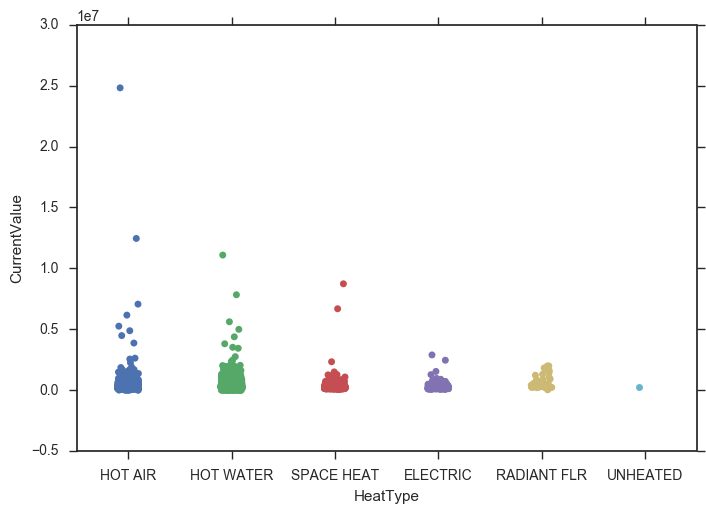

In [15]:
sns.stripplot(x="HeatType", y="CurrentValue", data=train_df, jitter=True);
plt.show()

Grade
-----
Cleaning of Grade

In [16]:
print(train_df['Grade'].value_counts())

# reassign uncommon values
train_df.loc[train_df["Grade"] == "CUSTOM", "Grade"] = "AVERAGE"
train_df.loc[train_df["Grade"] == "CUSTOM PLUS", "Grade"] = "AVERAGE"
train_df.loc[train_df["Grade"] == "CUSTOM MINUS", "Grade"] = "AVERAGE"
train_df.loc[train_df["Grade"] == "FAIR PLUS", "Grade"] = "FAIR"
train_df.loc[train_df["Grade"] == "FAIR MINUS", "Grade"] = "FAIR"
train_df.loc[train_df["Grade"] == "AVERAGEMINUS", "Grade"] = "AVERAGE"
train_df.loc[train_df["Grade"] == "AVERAGE PLUS", "Grade"] = "AVERAGE"
train_df.loc[train_df["Grade"] == "GOOD MINUS", "Grade"] = "GOOD"
train_df.loc[train_df["Grade"] == "GOOD PLUS", "Grade"] = "GOOD"
train_df.loc[train_df["Grade"] == "VRYGOODMINUS", "Grade"] = "VERY GOOD"
train_df.loc[train_df["Grade"] == "VRYGOODPLUS", "Grade"] = "VERY GOOD"
train_df.loc[train_df["Grade"] == "EXCLNT MINUS", "Grade"] = "EXCELLENT"
train_df.loc[train_df["Grade"] == "EXCLT PLUS", "Grade"] = "EXCELLENT"
train_df.loc[train_df["Grade"] == "POOR PLUS", "Grade"] = "POOR"
train_df.loc[train_df["Grade"] == "POOR MINUS", "Grade"] = "POOR"
train_df.loc[train_df["Grade"] == "CUSTOM", "Grade"] = "AVERAGE"

# Fill missing values
train_df["Grade"] = train_df["Grade"].fillna("AVERAGE")

print(train_df['Grade'].value_counts())

FAIR PLUS       1928
AVERAGEMINUS    1920
AVERAGE         1908
AVERAGE PLUS    1157
GOOD            1037
GOOD MINUS       623
GOOD PLUS        241
FAIR             189
VRYGOODMINUS     119
VRYGOODPLUS      110
VERY GOOD         97
EXCLNT MINUS      45
FAIR MINUS        33
EXCELLENT         12
EXCLT PLUS        10
CUSTOM             4
CUSTOM MINUS       3
POOR PLUS          2
POOR               1
CUSTOM PLUS        1
Name: Grade, dtype: int64
AVERAGE      4993
FAIR         2150
GOOD         1901
VERY GOOD     326
EXCELLENT      67
POOR            3
Name: Grade, dtype: int64


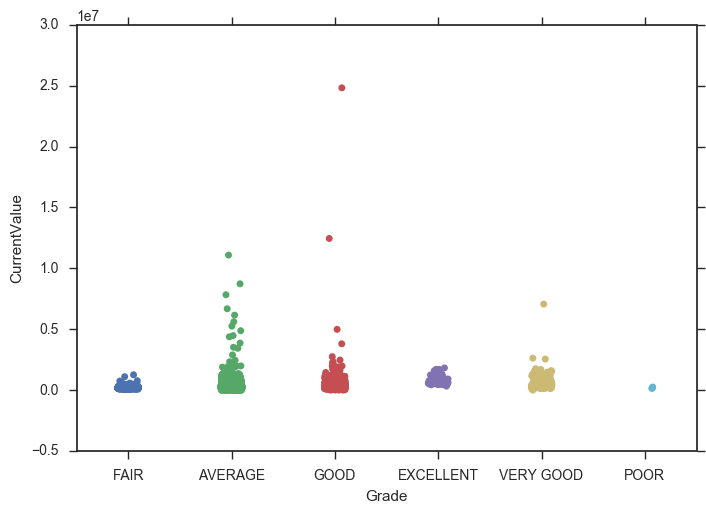

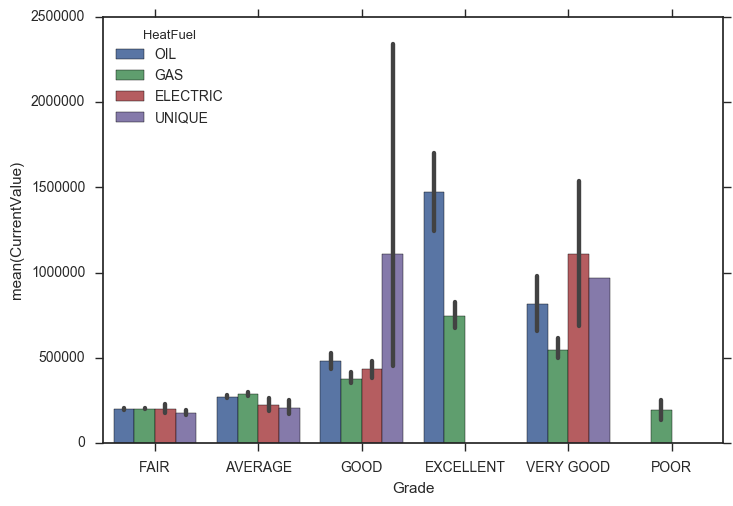

In [17]:
sns.stripplot(x="Grade", y="CurrentValue", data=train_df, jitter=True);
plt.show()

sns.barplot(x="Grade", y="CurrentValue", hue="HeatFuel", data=train_df);

#sns.violinplot(x="Grade", y="TotalGrossArea", data=train_df);

Bath
----
Split bath into several columns

In [18]:
wholedf['Baths'] = wholedf[['Bath1,Bath2']].apply(lambda x: pd.Series(str(x).split('/')))

NameError: name 'wholedf' is not defined


BuildingType x


CurrentAcres, TotalGrossArea, FinishedArea, CurrentValue, CurrentLandValue, 
CurrentYardItemsValue, CurrentBuildingValue, YearBlt, Depreciation, 

LandUse  x

HeatFuel x  
HeatType   x  
Grade    x 
NumofRooms s
NumofBedrooms s
Bath1 s
Bath2 s   
NumofUnits s


CurrentAcres, TotalGrossArea, FinishedArea, CurrentValue, CurrentLandValue, 
CurrentYardItemsValue, CurrentBuildingValue, YearBlt, Depreciation, LandUse, BuildingType, HeatFuel, HeatType, Grade, 
NumofRooms, NumofBedrooms, Bath1, Bath2, NumofUnits


SalePrice   

In [ ]:
# All values that are being treated as direct features
CurrentAcres = train_df['CurrentAcres']
TotalGrossArea = train_df['TotalGrossArea']
FinishedArea = train_df['FinishedArea']
CurrentValue = train_df['CurrentValue']
CurrentLandValue = train_df['CurrentLandValue']
CurrentYardItemsValue = train_df['CurrentYardItemsValue']
CurrentBuildingValue = train_df['CurrentBuildingValue']
#YearBlt = train_df['YearBlt']
Depreciation = train_df['Depreciation']

# LandUse = train_df['LandUse']
NumofUnits = train_df['NumofUnits']
#Baths = train_df['Baths']
NumofRooms = train_df['NumofRooms']
NumofBedrooms = train_df['NumofBedrooms']

# Features that are split out to binary
LandUse = pd.get_dummies( train_df['LandUse'] , prefix = 'LandUse')
HeatFuel = pd.get_dummies( train_df['HeatFuel'] , prefix = 'HeatFuel')
HeatType = pd.get_dummies( train_df['HeatType'] , prefix = 'HeatType')
Grade = pd.get_dummies( train_df['Grade'] , prefix = 'Grade')
#NumofRooms = pd.get_dummies( train_df['NumofRooms'] , prefix = 'NumofRooms')
#NumofBedrooms = pd.get_dummies( train_df['NumofBedrooms'] , prefix = 'NumofBedrooms')
#Baths = pd.get_dummies( train_df['Baths'] , prefix = 'Baths')
#NumofUnits = pd.get_dummies( train_df['NumofUnits'] , prefix = 'NumofUnits')

SalePrice = train_df['SalePrice']



In [ ]:
# removed year built
train_X = pd.concat([CurrentAcres, TotalGrossArea, FinishedArea, CurrentValue, CurrentLandValue, 
CurrentYardItemsValue, CurrentBuildingValue, Depreciation, LandUse, HeatFuel, HeatType, Grade, 
NumofRooms, NumofBedrooms, NumofUnits], axis=1)
train_X.head()

# This is just to determing correlation with survived to see how well it worked
train_corr = pd.concat([SalePrice, CurrentAcres, TotalGrossArea, FinishedArea, CurrentValue, CurrentLandValue, 
CurrentYardItemsValue, CurrentBuildingValue, Depreciation, LandUse, HeatFuel, HeatType, Grade, 
NumofRooms, NumofBedrooms, NumofUnits], axis=1)

In [ ]:
corr = train_corr.corr()
sns.heatmap(corr)
plt.show()

train_corr.corr()['SalePrice']

In [ ]:
splitmissing = train_corr[train_corr['SalePrice'].isnull()]
splithas =  train_corr[train_corr['SalePrice'].notnull()]

#train_corr.info()
#splithas.info()
#splitmissing.info()

# splithas.head()['SalePrice']
# splitmissing.head()['SalePrice']

In [ ]:
# Create all datasets that are necessary to train, validate and test models
train_valid_X = splithas
train_valid_y = splithas['SalePrice']
test_X = splitmissing
train_X , valid_X , train_y , valid_y = train_test_split( train_valid_X , train_valid_y , train_size = .7 )


In [ ]:
model = LassoLarsCV()
#model = Ridge()
#model = RandomForestRegressor()
#model = LogisticRegression()


#model = RandomForestClassifier()
#model = SVC()
#model = GradientBoostingClassifier()
#model = KNeighborsClassifier(n_neighbors = 3)
#model = GaussianNB()



In [ ]:
model.fit( train_X , train_y )

In [ ]:
# Score the model
print (model.score( train_X , train_y ) , model.score( valid_X , valid_y ))

In [ ]:
ParcelID = test_X.ParcelID
result = model.predict(test_X)

# output = pd.DataFrame( { 'id': id , 'SalePrice': result}, columns=['id', 'SalePrice'] )
output = pd.DataFrame( { 'ParcelID': ParcelID , 'SalePrice': result} )
output = output[['ParcelID', 'SalePrice']]

output.to_csv("solution.csv", index = False)
output.head(10)

In [ ]:



# This takes the age and breaks it into precentiles
# #print(np.percentile(train_df['CurrentAcres'],[0,33,66,100]))
# print(np.percentile(test_df['CurrentAcres'],[0,33,66,100]))
# farepercentile = [0, .09, .19, 29]

# Creates a new column binning the ages in to brackets and labeling them with numbers.  
# Prencentiles In this case are 0-7, 7=14, 14-31 and 31-513)
# train_df["CurrentAcresBin"] = pd.cut(train_df['CurrentAcres'],farepercentile, labels=["Low","Mid","High"])
#test_df["CurrentAcresBin"] = pd.cut(test_df['CurrentAcres'],farepercentile, labels=["Low","Mid","High"])

# plot the result
# sns.swarmplot(x="CurrentAcresBin", y="SalePrice", hue="Bath1", data=train_df)
# plt.show()

In [ ]:


# Embarked only in train_df, fill the two missing values with the most occurred value, which is "S".
# train_df["Embarked"].value_counts() 
# train_df["Embarked"] = train_df["Embarked"].fillna("S")

# Fill in the single missing fare with median value
#test_df["Fare"].fillna(test_df["Fare"].median(), inplace=True)
                                           
# Convert fare from float to int
#train_df['Fare'] = train_df['Fare'].astype(int)

In [ ]:
#propertyd = property.ix[:,'LandUse':'Depreciation']
#propertyone = propertyd[(property['LandUse'] == '1 Family') & (property['CurrentValue'] < 400000) & (property['NumofRooms'] < 40)]
#propertytwo = propertyd[(property['LandUse'] == '2 Family') & (property['CurrentValue'] < 400000) & (property['NumofRooms'] < 40)]
#propertythree = propertyd[(property['LandUse'] == '3 Family') & (property['CurrentValue'] < 400000) & (property['NumofRooms'] < 40)]
#propertyfour = propertyd[(property['LandUse'] == '4 Family') & (property['CurrentValue'] < 400000) & (property['NumofRooms'] < 40)]
#propertycondo = propertyd[(property['LandUse'] == 'Residential Condo') & (property['CurrentValue'] < 400000) & (property['NumofRooms'] < 40)]
